Import

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from tqdm import tqdm
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.stats import gaussian_kde, norm

# Pyro imports for probabilistic modeling and inference
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.optim import Adam as PyroAdam
from pyro.infer import SVI, Trace_ELBO


Seed, device, plot settings

In [33]:
seed = np.random.randint(1, 10000)
print(f"{seed}")

#seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100

4396
Running on CUDA


RealNVP model

In [34]:
class RealNVPBlock(PyroModule):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        assert in_features % 2 == 0, "Input feature dimension must be even."
        self.in_features = in_features
        self.hidden_features = hidden_features

        # Stochastic layers using PyroSample
        self.net_s = self._build_network(in_features // 2, hidden_features)
        self.net_t = self._build_network(in_features // 2, hidden_features)

    def _build_network(self, in_features, hidden_features):
        return PyroModule[nn.Sequential](
            PyroModule[nn.Linear](in_features, hidden_features),
            nn.ReLU(),
            PyroModule[nn.Linear](hidden_features, hidden_features * 2),
            nn.ReLU(),
            PyroModule[nn.Linear](hidden_features * 2, hidden_features * 2),
            nn.ReLU(),
            PyroModule[nn.Linear](hidden_features * 2, hidden_features),
            nn.ReLU(),
            PyroModule[nn.Linear](hidden_features, in_features)
        )

    def forward(self, x):
        assert x.shape[1] % 2 == 0, "Input must have an even number of features to split"
        x_a, x_b = x.chunk(2, dim=1)  # Split input
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        # Affine transformation logic here
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)

        return x_b * torch.exp(s) + t, s.sum(dim=1)  # ldj: log-determinant Jacobian


    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)


In [35]:
class RealNVP(PyroModule):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.blocks = PyroModule[nn.ModuleList]([RealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])

        # Prior for the latent space
        self.prior = PyroSample(dist.MultivariateNormal(
            torch.zeros(in_features).to(device),
            torch.eye(in_features).to(device)
        ))

    def forward(self, x, *args, **kwargs):  # Accept additional arguments
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))  # Flip for alternating updates
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x


Nan checker

In [36]:
def check_for_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

Inicializacija uteži in dataseta

In [37]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

### MAIN

podatki

In [38]:
with open('/PATH_TO_FILE/data_parsed.json') as f:
    data = json.load(f)


vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

#katerih najmanj
min_length = min(
    len(data['sdrec']['energy']),
    len(data['sdrec']['theta']),
    len(data['sdrec']['phi']),
    len(data['sdrec']['l']),
    len(data['sdrec']['b']),
    len(data['sdrec']['ra']),
    len(data['sdrec']['dec']),
    len(data['fdrec']['dEdXmax']),
    len(data['fdrec']['distXmax']),
    len(data['fdrec']['heightXmax']),
    len(data['fdrec']['xmax']),
    len(data['fdrec']['totalEnergy'])
)
print(f"minlen: {min_length}")


data_values = np.array([
    data['sdrec']['energy'][:min_length],
    data['sdrec']['theta'][:min_length],
    data['sdrec']['phi'][:min_length],
    data['sdrec']['l'][:min_length],
    data['sdrec']['b'][:min_length],
    data['sdrec']['ra'][:min_length],
    data['sdrec']['dec'][:min_length],
    data['fdrec']['dEdXmax'][:min_length],
    data['fdrec']['distXmax'][:min_length],
    data['fdrec']['heightXmax'][:min_length],
    data['fdrec']['xmax'][:min_length],
    data['fdrec']['totalEnergy'][:min_length]
]).T


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)




dataset = CustomDataset(data_scaled)

minlen: 1565


Split + dataloader

In [39]:
torch.manual_seed(seed)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_data_scaled = torch.utils.data.Subset(data_scaled, train_dataset.indices)
val_data_scaled = torch.utils.data.Subset(data_scaled, val_dataset.indices)
test_data_scaled = torch.utils.data.Subset(data_scaled, test_dataset.indices)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# PAZI data_scaled je Pytorch subset potrebujemo tensor
tds_tensor = torch.stack([torch.tensor(x) for x in test_data_scaled])  # vsak mora biti tensor

# pytorch -> numpy tenzor
tds_tensor = tds_tensor.numpy()



Hyperparameters + optim

In [40]:
dim = data_scaled.shape[1]
num_blocks = 8
hidden_features = 256
learning_rate = 1e-4
num_epochs = 200
visualize_epochs = [1, 100, 150]

# Initialize the RealNVP model with Pyro
model = RealNVP(num_blocks, dim, hidden_features).to(device)

# Define the Pyro SVI optimizer
pyro_optimizer = PyroAdam({"lr": learning_rate})

Guide

In [41]:
# Define the guide (variational distribution) for SVI
def guide(model, x=None):
    for name, module in model.named_modules():
        if isinstance(module, PyroModule[nn.Linear]):
            module.weight = PyroSample(dist.Normal(
                torch.zeros_like(module.weight),
                torch.ones_like(module.weight)
            ).to_event(2))
            if module.bias is not None:
                module.bias = PyroSample(dist.Normal(
                    torch.zeros_like(module.bias),
                    torch.ones_like(module.bias)
                ).to_event(1))



# Loss function for SVI: Trace_ELBO is the ELBO (Evidence Lower Bound)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


Train function

In [42]:
def train_real_nvp(model, train_loader, val_loader, svi, num_epochs, visualize_epochs):
    best_val_loss = float('inf')
    best_model_weights = None
    train_loss_list = []
    val_loss_list = []
    patience = 5  # Early stopping patience

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x in train_loader:
            x = x.to(device)
            x = torch.clamp(x, min=-10, max=10)
            loss = svi.step(model, x)  # Use SVI to optimize
            train_loss += loss

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                x = torch.clamp(x, min=-10, max=10)
                loss = svi.evaluate_loss(x)
                val_loss += loss

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best weights after training
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_realnvp_svi_model.pth")
    
    return train_loss_list, val_loss_list


Poženi

In [43]:
train_loss, val_loss = train_real_nvp(model, train_loader, val_loader, svi, num_epochs, visualize_epochs)

AttributeError: 'RealNVP' object has no attribute 'chunk'

### EVAL

Plot Loss function

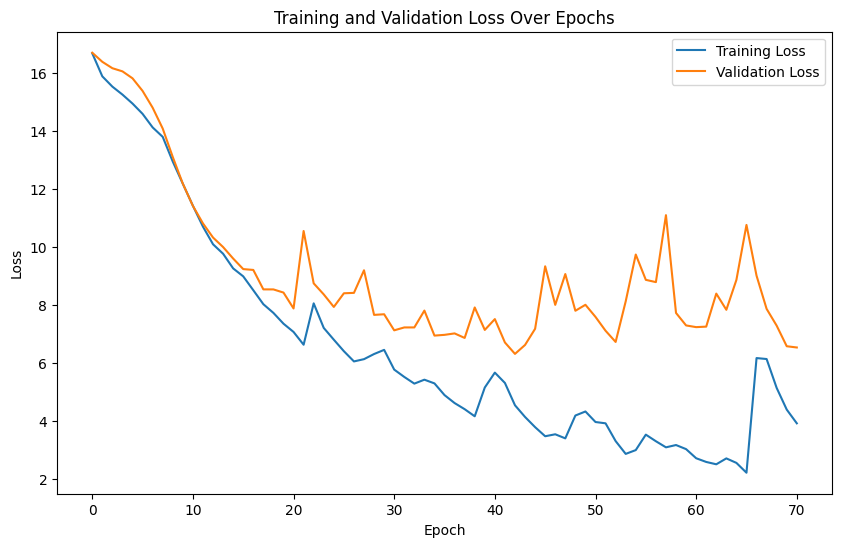

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"/home/fedja-mocnik/Documents/IJS/slike_model/Pierre/12d/Loss_plot.png")
plt.show()

Overlap function + risanje za visoko dim podatke

In [31]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.detach().numpy().T
    generated_samples_np = generated_samples.detach().numpy().T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

In [32]:
def plot_samples(samples):

    vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]


    num_features = samples.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
    if num_features == 1:
        axs = [axs]
    for i in range(num_features):
        kde = gaussian_kde(samples[:, i])
        x_range = np.linspace(samples[:, i].min(), samples[:, i].max(), 1000)
        axs[i].plot(x_range, kde(x_range), label='Estimated Density')
        axs[i].set_title(f'{vals[i]}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    plt.suptitle(f'Sample Distributions at Final Epoch ')
    plt.tight_layout()
    plt.savefig(f'samples_epoch_final.png')
    plt.show()
    plt.close()

In [33]:
def plot_high_dimensional_samples(original_samples, generated_samples, method="PCA", title=""):
    original_samples = original_samples.detach().numpy()
    generated_samples = generated_samples.detach().numpy()

    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "t-SNE":
        reducer = TSNE(n_components=2)

    original_reduced = reducer.fit_transform(original_samples)
    generated_reduced = reducer.fit_transform(generated_samples)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=original_reduced[:, 0], y=original_reduced[:, 1], label='Original', alpha=0.5)
    sns.scatterplot(x=generated_reduced[:, 0], y=generated_reduced[:, 1], label='Generated', alpha=0.5)
    plt.title(f"{title} - {method} Visualization")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.savefig(f"/home/fedja-mocnik/Documents/IJS/slike_model/Pierre/12d/{title}_{method}.png")
    plt.show()

Izpisi 

Final probability of 12D data overlap: 0.2849
generirani: 


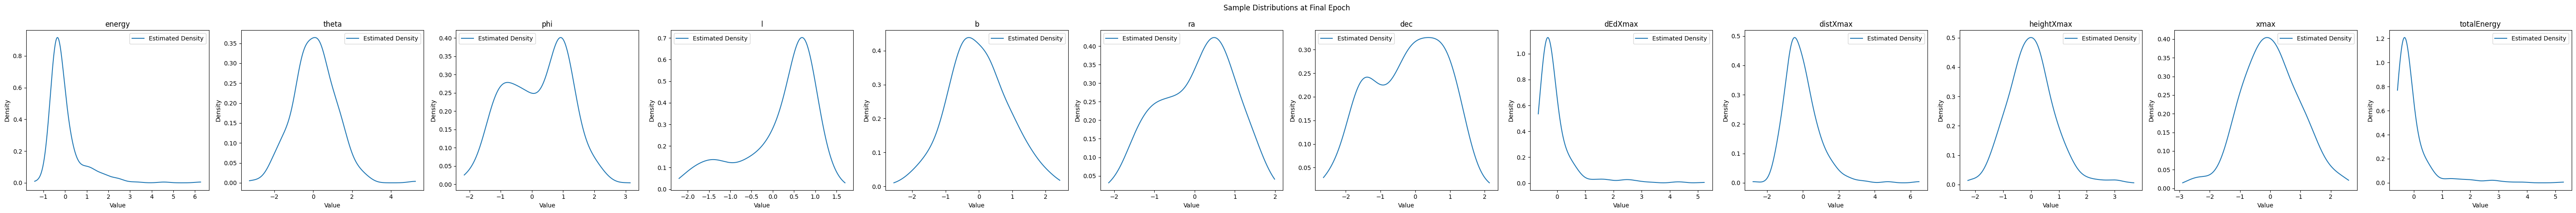

originalni: 


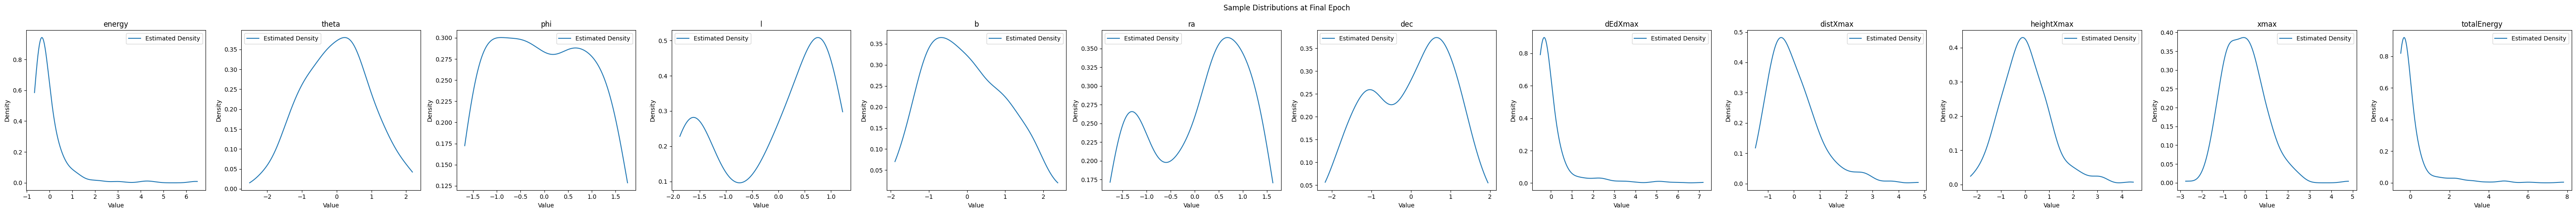

In [56]:
model.eval()
with torch.no_grad():
    generated_samples = model.sample(len(test_dataset)).cpu()

    # Overlap
    original_samples = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
    overlap_probability_12d = compute_data_overlap(original_samples, generated_samples)
    print(f"Final probability of 12D data overlap: {overlap_probability_12d:.4f}")


    print("generirani: ")
    plot_samples(generated_samples)


    print("originalni: ")
    plot_samples(original_samples)

    #PCA
    #plot_high_dimensional_samples(original_samples, generated_samples, method="PCA", title="Final: Original vs Generated - PCA")

    #t-SNE
    #plot_high_dimensional_samples(original_samples, generated_samples, method="t-SNE", title="Final: Original vs Generated - t-SNE")

In [35]:
# model.eval()
# array_prob = []

# for i in range(800):
#     with torch.no_grad():
#         generated_samples = model.sample(len(test_dataset)).cpu()

#         # Overlap
#         original_samples = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
#         array_prob.append(compute_data_overlap(original_samples, generated_samples))


# hist, bins = np.histogram(array_prob, bins=20)
# mean = np.mean(array_prob)
# std = np.std(array_prob)

# plt.stairs(hist, bins, linewidth=1.5)
# plt.legend(title=fr'mean = {np.round(mean,3)},$\sigma$ = {np.round(std, 3)}')
# plt.vlines(mean, ymin=0, ymax=100, colors="orange")

# print(np.max(array_prob))


In [36]:
def inverse_transform_generate(model, num_samples, dim):
    """
    Generate data using the inverse of the RealNVP model starting from a Gaussian distribution.
    
    Parameters:
    - model (RealNVP): The trained RealNVP model.
    - num_samples (int): Number of samples to generate.
    - dim (int): The dimensionality of the data.
    
    Returns:
    - generated_samples (np.array): Array of generated samples.
    """
    with torch.no_grad():
        # normalna distribucija
        z = torch.randn(num_samples, dim).to(device) #a je tukaj random kul?
        
        # inverz modela, da dobimo zeleno
        generated_samples = model.backward(z).cpu().numpy()
    
    return generated_samples

In [47]:
num_samples = len(tds_tensor)
generated_data = inverse_transform_generate(model, num_samples, dim)

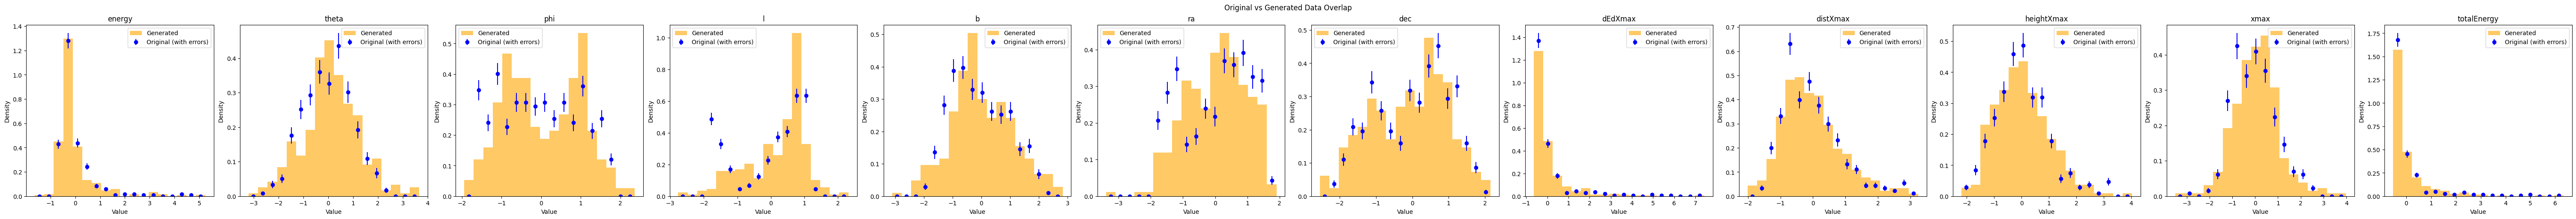

In [48]:
def plot_histogram_overlap(original_data, generated_data, vals, bins=18):
    """
    Plot overlapping histograms of original and generated data with sqrt(n) error bars for the original data.
    
    Parameters:
    - original_data (np.array): Original data from the dataset.
    - generated_data (np.array): Data generated by the model.
    - vals (list of str): List of labels for each feature.
    - bins (int): Number of bins to use for histograms.
    """

    vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

    num_features = 12 #original_data.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5), constrained_layout=True)
    
    if num_features == 1:
        axs = [axs]
    
    for i in range(num_features):
        # Originalni + 
        counts, bin_edges = np.histogram(original_data[:, i], bins=bins, density=True, range=(np.min(generated_data[:,i]), np.max(generated_data[:,i])))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts / len(original_data))  # sqrt(n) error bars
        axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Original (with errors)', color='blue')

        # Histogrami za generirane
        axs[i].hist(generated_data[:, i], bins=bins, density=True, alpha=0.6, label='Generated', color='orange')
        
        axs[i].set_title(f'{vals[i]}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.suptitle('Original vs Generated Data Overlap')
    plt.savefig(f"overlap_histograms.png")
    plt.show()

plot_histogram_overlap(tds_tensor, generated_data, vals)
